In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)



# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# recent_date = session.query(measurement).order_by(measurement.id, measurement.date).first()
# print(recent_date)
last_date = session.query(measurement.date).order_by(measurement.id.desc(), measurement.date).first()[0]
print(last_date)

2017-08-23


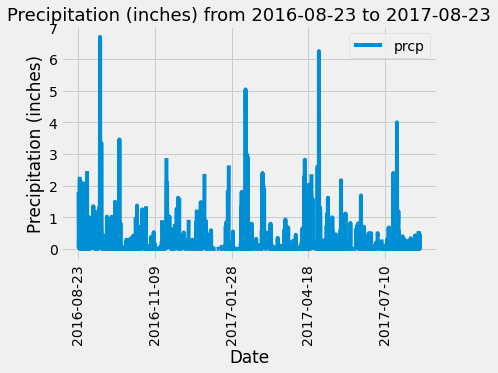

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
last_date = (dt.datetime.strptime(last_date, "%Y-%m-%d")).date()
date_oneyearago = last_date - dt.timedelta(days=365)
date_oneyearago

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp).\
            filter((measurement.date >= date_oneyearago)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)#.set_index("date")
# print(prcp_df)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x="date", y="prcp", rot=90)
plt.title(f"Precipitation (inches) from {date_oneyearago} to {last_date}", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

# plt.tight_layout()
plt.savefig("Images/prcp.png")
# plt.show()




In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
num_station = session.query(station).count()
num_station

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  order_by(func.count(measurement.station).desc()).\
                  group_by(measurement.station).\
                  all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
# most_active_station
lowest_temp = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
# lowest_temp
highest_temp = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
# highest_temp
avg_temp = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
# avg_temp
print(f"Lowest temperature: {lowest_temp} degrees Fahrenheit.")
print(f"Highest temperature: {highest_temp} degrees Fahrenheit.")
print(f"Average temperature: {round(avg_temp, 2)} degrees Fahrenheit.")


Lowest temperature: 54.0 degrees Fahrenheit.
Highest temperature: 85.0 degrees Fahrenheit.
Average temperature: 71.66 degrees Fahrenheit.


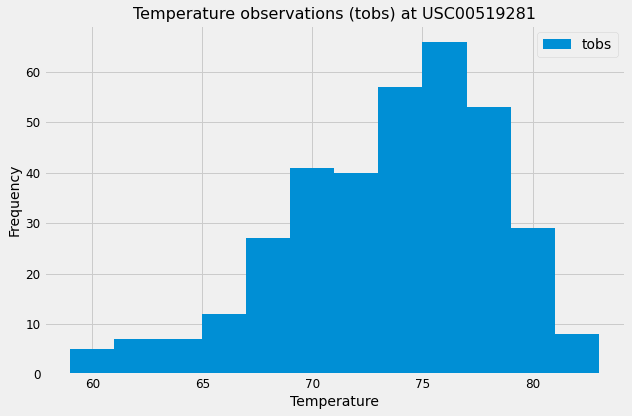

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == most_active_station)\
                                        & (measurement.date >= date_oneyearago)\
                                        & (measurement.date <= last_date)).all())

most_active_tobs.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations (tobs) at {most_active_station}", fontsize=16)

plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()


# Close session

In [16]:
# Close Session
session.close()